In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve, auc, accuracy_score


pd. set_option("display.max_columns", None)
pd. set_option("display.max_rows", None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
df_raw = pd.read_csv('credit_card_2015_2016.csv')

In [3]:
df_raw.head()

,term,sub_grade,grade,emp_length,issue_y,revol_util_n,int_rate_n,installment_n,tot_hi_cred_lim_n,dti_n,avg_cur_bal_n,all_util_n,acc_open_past_24mths_n,annual_inc_n,loan_amnt_n,loan_status
0,60 months,C4,C,10+ years,15,87.1,14.31,702.30,350349,36.91,35256,100,1,98000.0,29975,Fully Paid
1,60 months,C1,C,< 1 year,15,57.0,12.29,268.70,43525,18.80,2990,100,2,45000.0,12000,Fully Paid
2,36 months,B3,B,1 year,15,42.8,9.99,258.10,72655,19.34,6569,100,5,62500.0,8000,Fully Paid
3,36 months,A4,A,3 years,15,95.7,7.26,433.95,62695,11.31,9416,100,0,127000.0,14000,Fully Paid
4,36 months,B5,B,< 1 year,15,91.8,11.53,758.78,120674,23.07,7059,100,6,116000.0,23000,Fully Paid


In [4]:
df_raw.info() #emp_length has missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   term                    40000 non-null  object 
 1   sub_grade               40000 non-null  object 
 2   grade                   40000 non-null  object 
 3   emp_length              37459 non-null  object 
 4   issue_y                 40000 non-null  int64  
 5   revol_util_n            40000 non-null  float64
 6   int_rate_n              40000 non-null  float64
 7   installment_n           40000 non-null  float64
 8   tot_hi_cred_lim_n       40000 non-null  int64  
 9   dti_n                   40000 non-null  float64
 10  avg_cur_bal_n           40000 non-null  int64  
 11  all_util_n              40000 non-null  int64  
 12  acc_open_past_24mths_n  40000 non-null  int64  
 13  annual_inc_n            40000 non-null  float64
 14  loan_amnt_n             40000 non-null

In [18]:
# Separate training and OOT data
df_train = df_raw[df_raw['issue_y'] == 15].copy()
df_oot = df_raw[df_raw['issue_y'] == 16].copy()

print(df_train.shape, df_oot.shape)

(20000, 16) (20000, 16)


In [19]:
df_train.info() # emp_length has missing values

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   term                    20000 non-null  object 
 1   sub_grade               20000 non-null  object 
 2   grade                   20000 non-null  object 
 3   emp_length              18747 non-null  object 
 4   issue_y                 20000 non-null  int64  
 5   revol_util_n            20000 non-null  float64
 6   int_rate_n              20000 non-null  float64
 7   installment_n           20000 non-null  float64
 8   tot_hi_cred_lim_n       20000 non-null  int64  
 9   dti_n                   20000 non-null  float64
 10  avg_cur_bal_n           20000 non-null  int64  
 11  all_util_n              20000 non-null  int64  
 12  acc_open_past_24mths_n  20000 non-null  int64  
 13  annual_inc_n            20000 non-null  float64
 14  loan_amnt_n             20000 non-null  int

Create the dichotomous output variable 'Outcome' by combining Charge off (which is actual loss) with Late (31-120 days) which is likely to be a loss

In [20]:
# Create Outcome variable (simply put, 1 means bad  or risky loan, 0 means good loan)
df_train['Outcome'] = df_train['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Late (31-120 days)'] else 0)
print(df_train['Outcome'].value_counts())
print(df_train['Outcome'].value_counts(normalize=True))

Outcome
0    16401
1     3599
Name: count, dtype: int64
Outcome
0    0.82005
1    0.17995
Name: proportion, dtype: float64


In [21]:
# Basic information of categorical data
print("Counts of categorical features:\n", df_train.describe(include=['object', 'category']))
print('************Loan Status Counts******************')
print(df_train.value_counts(['loan_status']))
print(df_train['loan_status'].value_counts(normalize=True))
print('************Term Counts******************')
print(df_train.value_counts(['term']))
print(df_train['term'].value_counts(normalize=True))
print('*********Grade Counts*************')
print(df_train.value_counts(['grade']))
print(df_train['grade'].value_counts(normalize=True))
print('*********Sub Grade Counts*************')
print(df_train.value_counts(['sub_grade']))
print(df_train['sub_grade'].value_counts(normalize=True))

Counts of categorical features:
              term sub_grade  grade emp_length loan_status
count       20000     20000  20000      18747       20000
unique          2        34      7         11           3
top     36 months        A5      B  10+ years  Fully Paid
freq        15696      1606   6805       6099       16401
************Loan Status Counts******************
loan_status       
Fully Paid            16401
Charged Off            3413
Late (31-120 days)      186
Name: count, dtype: int64
loan_status
Fully Paid            0.82005
Charged Off           0.17065
Late (31-120 days)    0.00930
Name: proportion, dtype: float64
************Term Counts******************
term     
36 months    15696
60 months     4304
Name: count, dtype: int64
term
36 months    0.7848
60 months    0.2152
Name: proportion, dtype: float64
*********Grade Counts*************
grade
B        6805
A        5902
C        4760
D        1645
E         734
F         137
G          17
Name: count, dtype: int64
grade

As a part of feature engineering in experiment-2, create broader bins for emp_length (0 for 0-2 years, 1 for 3-5 years, 2 for 6-8 years and 3 for 9 and above)

In [22]:
# Map emp_length to ordinal numbers as per the feature definition ( Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years)
emp_length_map = {'< 1 year': 'le2', '1 year': 'le2', '2 years': 'le2', '3 years': '3to5', '4 years': '3to5',
                  '5 years': '3to5', '6 years': '6to8', '7 years': '6to8', '8 years': '6to8', '9 years': '9+', '10+ years': '9+'}

df_train['emp_length'] = df_train['emp_length'].map(emp_length_map)

# Check missing values
print(df_train['emp_length'].isnull().sum())

1253


In [23]:
print("\nBasic Statistics of Numerical features:\n", df_train.describe().round(2))


Basic Statistics of Numerical features:
        issue_y  revol_util_n  int_rate_n  installment_n  tot_hi_cred_lim_n  \
count  20000.0      20000.00    20000.00       20000.00           20000.00   
mean      15.0         56.52       10.79         451.95          173900.06   
std        0.0         22.25        3.75         246.46          177436.45   
min       15.0         -1.00        5.32          30.12            2700.00   
25%       15.0         39.90        7.89         267.21           50600.00   
50%       15.0         56.50        9.99         392.81          108749.00   
75%       15.0         73.53       12.99         602.30          249877.75   
max       15.0        124.70       27.88        1306.90         3754640.00   

          dti_n  avg_cur_bal_n  all_util_n  acc_open_past_24mths_n  \
count  20000.00       20000.00    20000.00                20000.00   
mean      18.93       12949.71       98.50                    4.43   
std        8.47       15657.95        8.37   

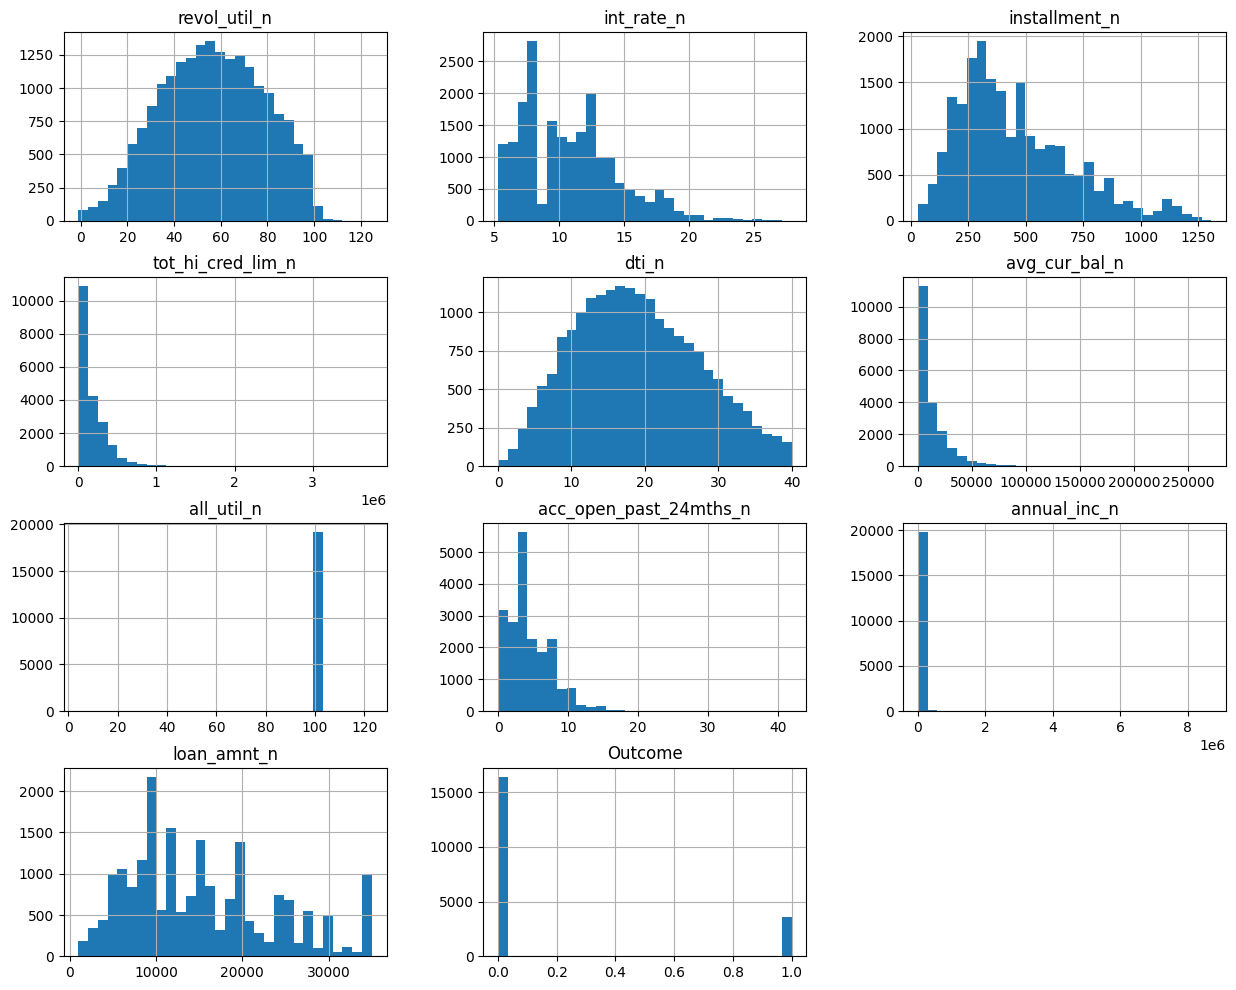

In [24]:
# Distribution plots for numerical features (excluding issue year)
num_cols = [col for col in df_train.select_dtypes(include='number').columns if col != 'issue_y']
df_train[num_cols].hist(figsize=(15, 12), bins=30)
plt.show()

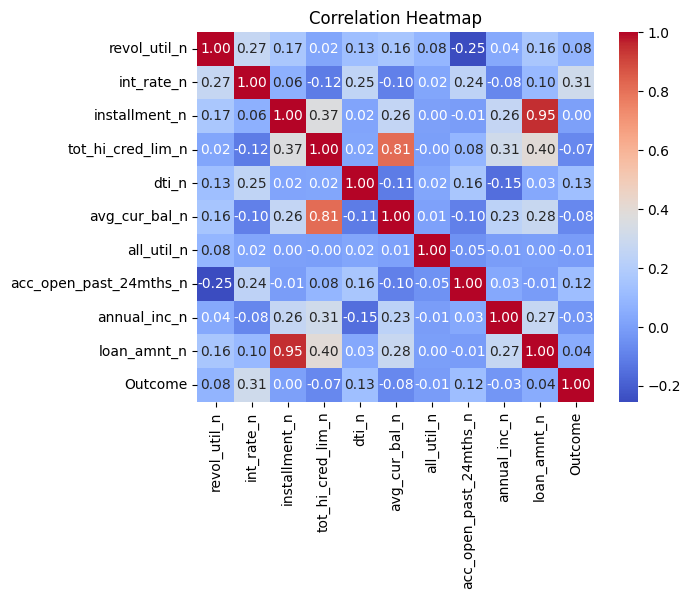

In [25]:
# Correlation map
# plt.figure(figsize=(12, 10))
sns.heatmap(df_train[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

As a part of data engineering in experimemt 2, perform the following:
1) loan_amnt_installment_n  = loan_amnt_n/installment_n (highly correlated)
2) tot_hi_cred_lim_avg_cur_bal_n = tot_hi_cred_lim_n/avg_cur_bal_n (highly correlated)
3) drop all_util_n as >19k out of 20k records has value 100

In [26]:
# 1. Create loan_amnt_installment_n = loan_amnt_n / installment_n
df_train['loan_amnt_installment_n'] = df_train['loan_amnt_n'] / df_train['installment_n']

# 2. Create tot_hi_cred_lim_avg_cur_bal_n = tot_hi_cred_lim_n / avg_cur_bal_n
df_train['tot_hi_cred_lim_avg_cur_bal_n'] = df_train['tot_hi_cred_lim_n'] / df_train['avg_cur_bal_n']

# 3. Drop all_util_n and other 4 columns from step1 and step2 used for feture engineering
df_train = df_train.drop(columns=['all_util_n'])
df_train = df_train.drop(columns=['loan_amnt_n','installment_n','tot_hi_cred_lim_n','avg_cur_bal_n'])

In [27]:
df_train.head()

,term,sub_grade,grade,emp_length,issue_y,revol_util_n,int_rate_n,dti_n,acc_open_past_24mths_n,annual_inc_n,loan_status,Outcome,loan_amnt_installment_n,tot_hi_cred_lim_avg_cur_bal_n
0,60 months,C4,C,9+,15,87.1,14.31,36.91,1,98000.0,Fully Paid,0,42.681190,9.937287
1,60 months,C1,C,le2,15,57.0,12.29,18.80,2,45000.0,Fully Paid,0,44.659472,14.556856
2,36 months,B3,B,le2,15,42.8,9.99,19.34,5,62500.0,Fully Paid,0,30.995738,11.060283
3,36 months,A4,A,3to5,15,95.7,7.26,11.31,0,127000.0,Fully Paid,0,32.261781,6.658347
4,36 months,B5,B,le2,15,91.8,11.53,23.07,6,116000.0,Fully Paid,0,30.311816,17.095056


In [29]:
#update num_cols
num_cols = [col for col in df_train.columns if col.endswith('_n')]
print(num_cols)

['revol_util_n', 'int_rate_n', 'dti_n', 'acc_open_past_24mths_n', 'annual_inc_n', 'loan_amnt_installment_n', 'tot_hi_cred_lim_avg_cur_bal_n']


Plot the numerical features against the Outcome variable

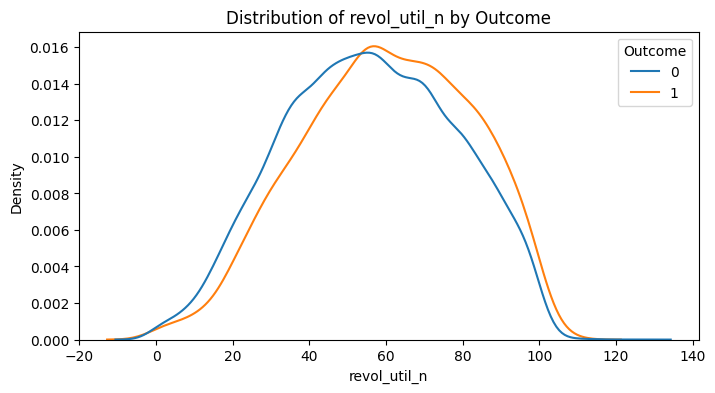

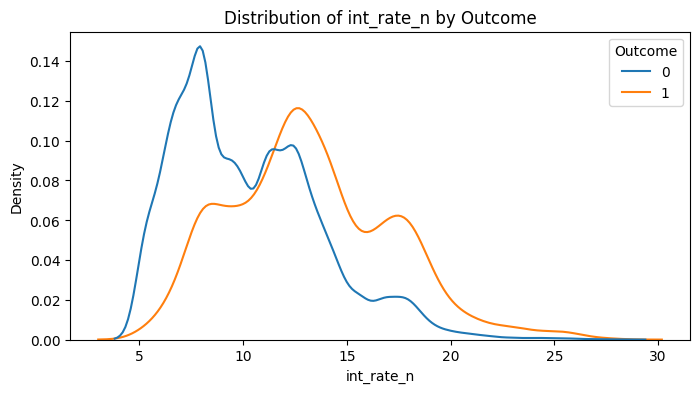

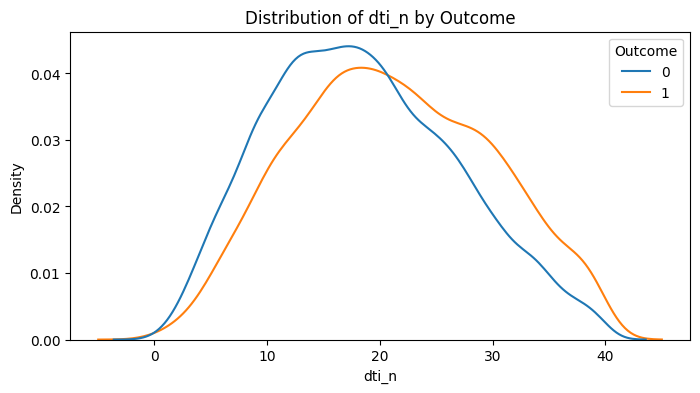

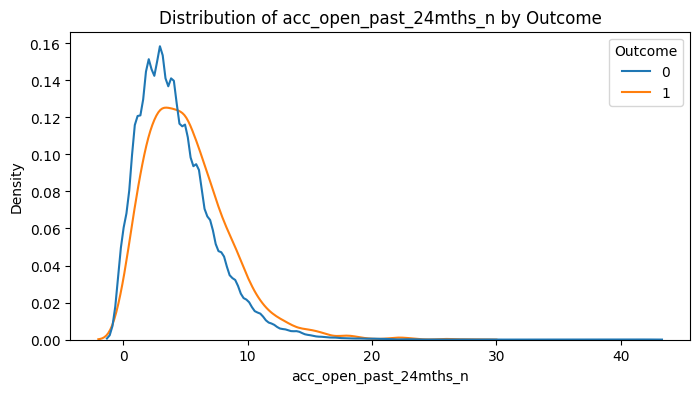

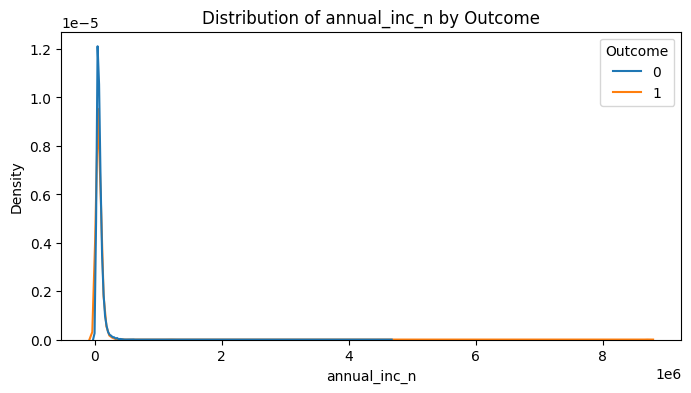

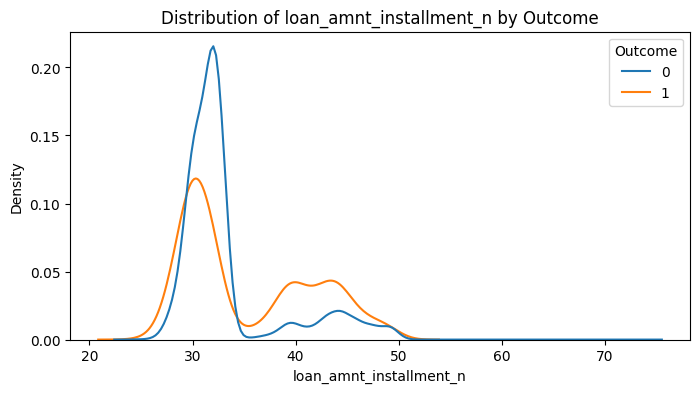

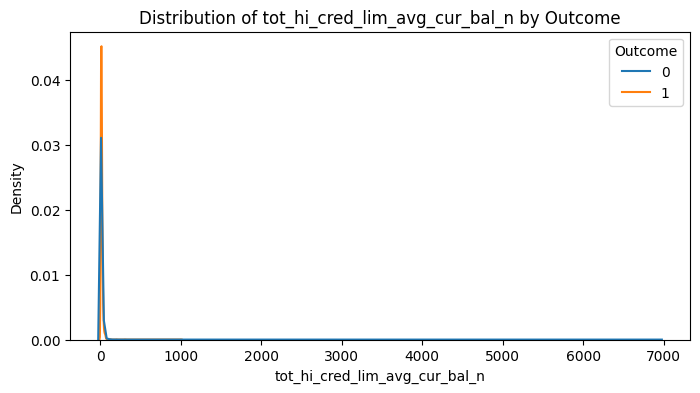

In [48]:
for feature in num_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df_train, x=feature, hue='Outcome', common_norm=False) #Common_norm false means each group’s density curve is normalized independently
    plt.title(f'Distribution of {feature} by Outcome')
    plt.show()

Boxplot and outlier check: xgboost is generally robust to outliers, but it may impact the generalizability of the model

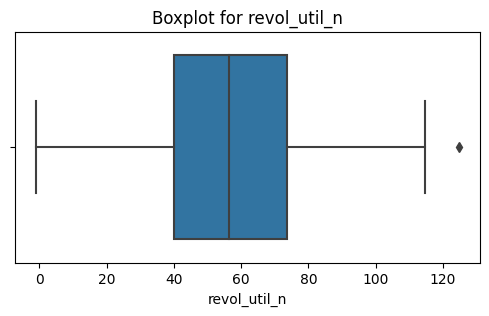

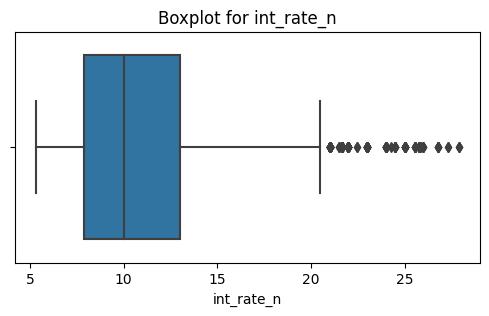

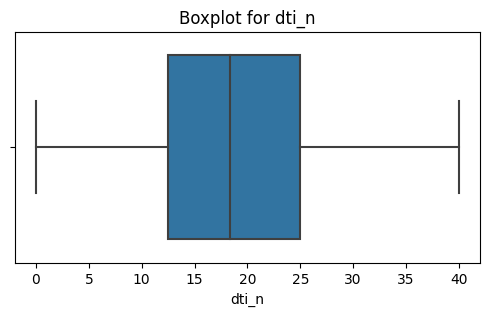

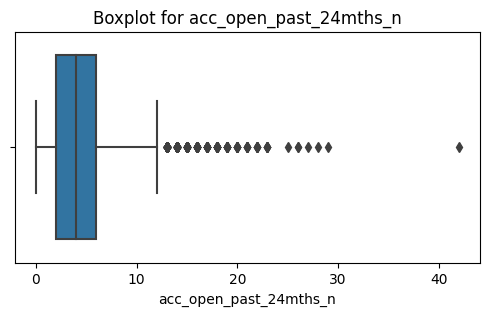

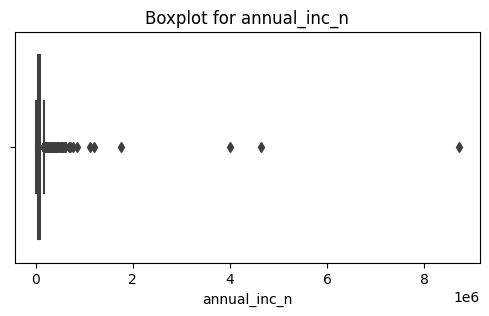

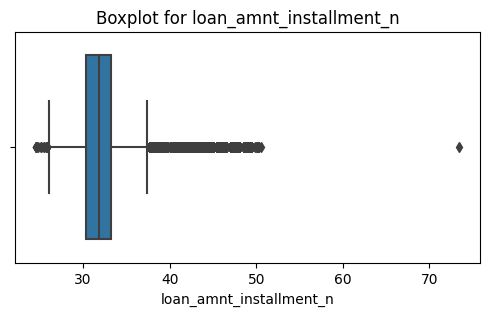

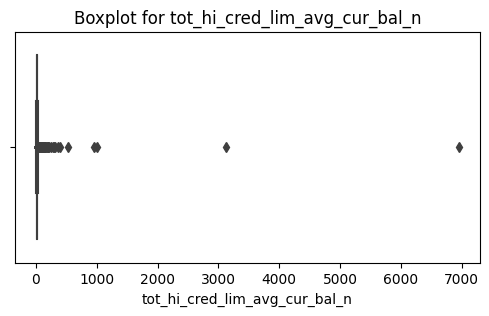

revol_util_n                        1
int_rate_n                        251
dti_n                               0
acc_open_past_24mths_n            397
annual_inc_n                      947
loan_amnt_installment_n          4082
tot_hi_cred_lim_avg_cur_bal_n     968
dtype: int64


In [30]:
# Check for outliers
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_train[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

# Outlier detection using IQR
Q1 = df_train[num_cols].quantile(0.25)
Q3 = df_train[num_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df_train[num_cols] < (Q1 - 1.5 * IQR)) | (df_train[num_cols] > (Q3 + 1.5 * IQR))).sum()
print(outliers)

Run t-test and Manwhitneyu to check if there is statistically significant difference between the means of a numerical variables for good and bad loans

Unlike the t-test, which compares means and assumes that the data are normally distributed and have equal variances, Mann-WhitneyU test does not require the data to be normally distributed and is suitable for data when the assumptions of the t-test are not met

In [31]:
results = []

for col in num_cols:
    group0 = df_train[df_train['Outcome'] == 0][col].dropna()
    group1 = df_train[df_train['Outcome'] == 1][col].dropna()
    
    # t-test
    t_stat, t_p = ttest_ind(group0, group1, equal_var=False)
    # Mann-Whitney U test
    u_stat, u_p = mannwhitneyu(group0, group1, alternative='two-sided')
    
    # Significance check (alpha = 0.05)
    t_significant = 'Significant' if t_p < 0.05 else 'Not Significant'
    u_significant = 'Significant' if u_p < 0.05 else 'Not Significant'
    
    results.append({
        'feature': col,
        't-test p-value': t_p,
        't-test significance': t_significant,
        'Mann-Whitney p-value': u_p,
        'Mann-Whitney significance': u_significant
    })

summary_df = pd.DataFrame(results)
print(summary_df)


                         feature  t-test p-value t-test significance  \
0                   revol_util_n    1.036634e-27         Significant   
1                     int_rate_n    0.000000e+00         Significant   
2                          dti_n    9.970022e-66         Significant   
3         acc_open_past_24mths_n    1.963690e-56         Significant   
4                   annual_inc_n    5.576249e-03         Significant   
5        loan_amnt_installment_n    2.921110e-70         Significant   
6  tot_hi_cred_lim_avg_cur_bal_n    9.528450e-01     Not Significant   

   Mann-Whitney p-value Mann-Whitney significance  
0          3.581338e-27               Significant  
1          0.000000e+00               Significant  
2          2.424016e-65               Significant  
3          1.675858e-64               Significant  
4          3.188651e-31               Significant  
5          1.978237e-09               Significant  
6          3.853879e-04               Significant  


In [52]:
# from scipy.stats import f_oneway
# import pandas as pd

# anova_results = []

# for col in num_cols:
#     # Extract the values for each Outcome group
#     groups = [df_train[df_train['Outcome'] == outcome][col].dropna() for outcome in df_train['Outcome'].unique()]
    
#     # Perform ANOVA if there are at least 2 groups with data
#     if len(groups) >= 2 and all(len(g) > 0 for g in groups):
#         f_stat, p_val = f_oneway(*groups)
#         anova_results.append({'Variable': col, 'F-statistic': f_stat, 'p-value': p_val})
#     else:
#         anova_results.append({'Variable': col, 'F-statistic': None, 'p-value': None})
    
# # Display results as a DataFrame
# anova_df = pd.DataFrame(anova_results)
# anova_df['Significant'] = np.where(anova_df['p-value'] < 0.05, 'Yes', 'No')
# print(anova_df)


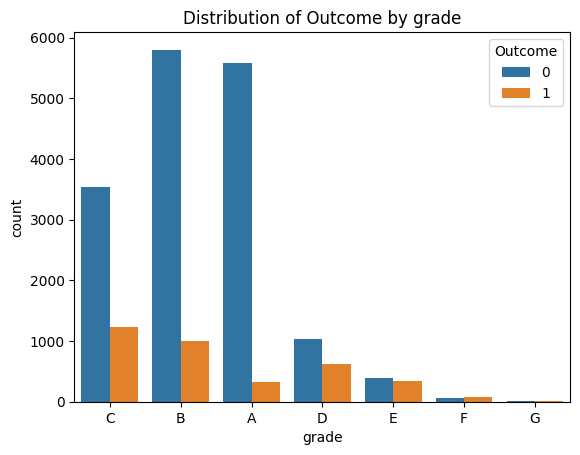

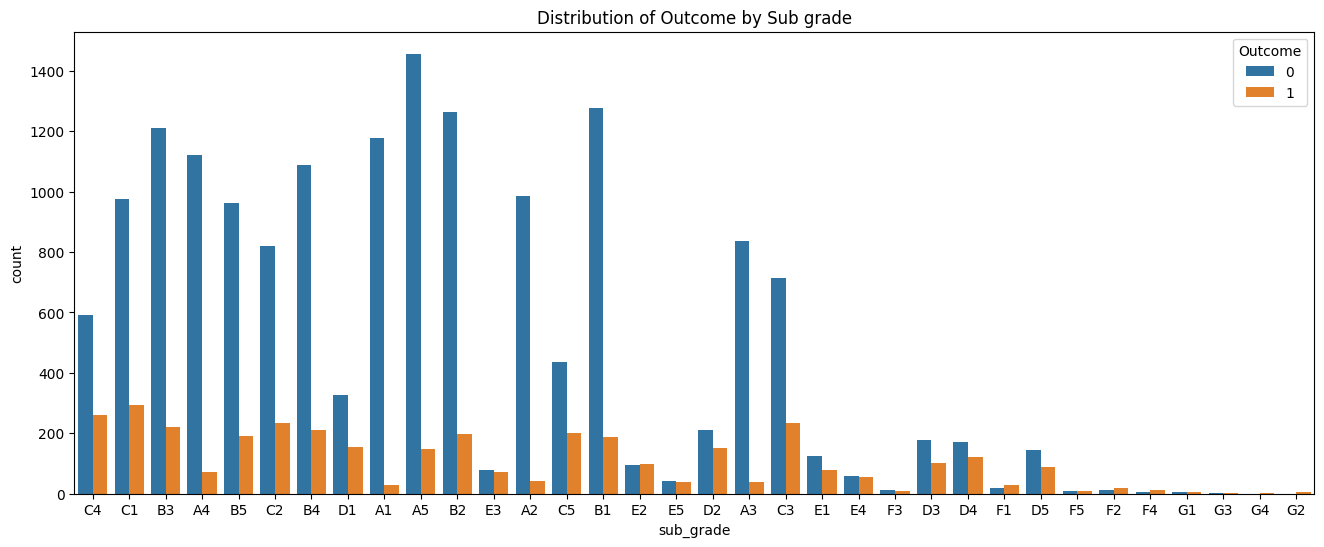

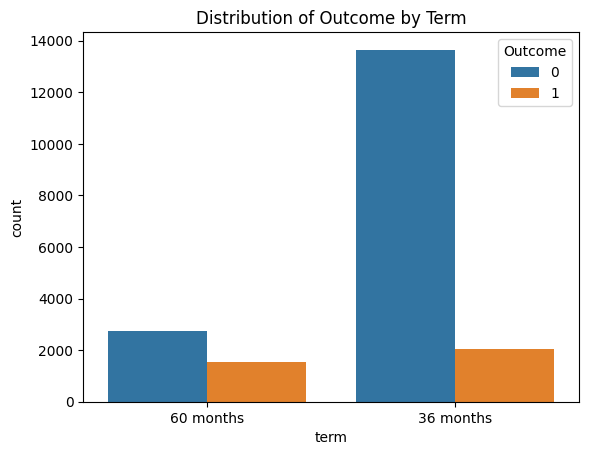

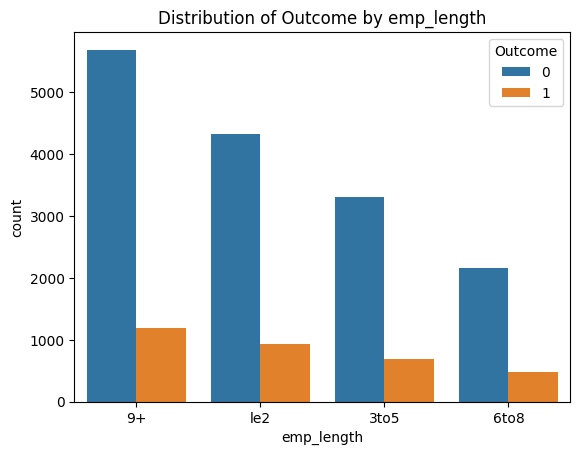

In [ ]:
#Plot categorical variables with Outcome variable

sns.countplot(data=df_train, x='grade', hue='Outcome')
plt.title('Distribution of Outcome by grade')
plt.show()

plt.figure(figsize=(16, 6))
sns.countplot(data=df_train, x='sub_grade', hue='Outcome')
plt.title('Distribution of Outcome by Sub grade')
plt.show()

sns.countplot(data=df_train, x='term', hue='Outcome')
plt.title('Distribution of Outcome by Term')
plt.show()

sns.countplot(data=df_train, x='emp_length', hue='Outcome')
plt.title('Distribution of Outcome by emp_length')
plt.show()

Create a separate category for missing values

In [ ]:
df_train['emp_length'] = df_train['emp_length'].fillna('missing')
print("\nMissing Values:\n", df_train['emp_length'].isnull().sum())


Missing Values:
 0


In [39]:
df_train['emp_length'].value_counts()

emp_length
9+         6875
le2        5252
3to5       3989
6to8       2631
missing    1253
Name: count, dtype: int64

Run the chi-square test to determine whether there is a significant relationship between the categorical variables and Outcome

In [41]:
cat_cols = ['term', 'grade', 'sub_grade','emp_length']
target = 'Outcome'

def chi_square_test(data, predictor, target):
    contingency_table = pd.crosstab(data[predictor], data[target])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

# Store results
results = []

for col in cat_cols:
    chi2, p = chi_square_test(df_train, col, target)
    significance = 'Significant' if p < 0.05 else 'Not Significant'
    results.append({'feature': col, 'chi2_stat': chi2, 'p_value': p, 'significance': significance})

# Display as DataFrame
results_df = pd.DataFrame(results)
print(results_df)


      feature    chi2_stat        p_value significance
0        term  1208.077035  1.071369e-264  Significant
1       grade  1838.200860   0.000000e+00  Significant
2   sub_grade  1961.877626   0.000000e+00  Significant
3  emp_length    45.912359   2.568476e-09  Significant


Since sub_grade is at more granular level of grade, there is a possibility they are closely associated. We can check with Cramer's V which measures the strength of association between two categorical variables 

In [42]:
contingency = pd.crosstab(df_train['grade'], df_train['sub_grade'])
chi2, p, dof, expected = chi2_contingency(contingency)
# Calculate Cramer’s V
n = contingency.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape)-1)))
print(cramers_v)

1.0


In [43]:
df_train_coded=df_train.copy()

In [44]:
# Encode categorical variables
le = LabelEncoder()
df_train_coded['sub_grade'] = le.fit_transform(df_train_coded['sub_grade'])
df_train_coded['grade'] = le.fit_transform(df_train_coded['grade'])
df_train_coded['term'] = le.fit_transform(df_train_coded['term'])
df_train_coded['emp_length'] = le.fit_transform(df_train_coded['emp_length'])

In [45]:
df_train_coded.head()

,term,sub_grade,grade,emp_length,issue_y,revol_util_n,int_rate_n,dti_n,acc_open_past_24mths_n,annual_inc_n,loan_status,Outcome,loan_amnt_installment_n,tot_hi_cred_lim_avg_cur_bal_n
0,1,13,2,2,15,87.1,14.31,36.91,1,98000.0,Fully Paid,0,42.681190,9.937287
1,1,10,2,3,15,57.0,12.29,18.80,2,45000.0,Fully Paid,0,44.659472,14.556856
2,0,7,1,3,15,42.8,9.99,19.34,5,62500.0,Fully Paid,0,30.995738,11.060283
3,0,3,0,0,15,95.7,7.26,11.31,0,127000.0,Fully Paid,0,32.261781,6.658347
4,0,9,1,3,15,91.8,11.53,23.07,6,116000.0,Fully Paid,0,30.311816,17.095056


Build the xgboost models using 5-fold cross-validation, repeated 3 times using different random seeds

In [55]:
X = df_train_coded.drop(['loan_status', 'Outcome', 'issue_y'], axis=1)
y = df_train_coded['Outcome']

def gini_score(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

# gini_scorer = make_scorer(gini_score, needs_proba=True)

results = []

# Define your random seeds for the 3 repetitions
seeds = [92, 123, 999]

for seed in seeds:
    # StratifiedKFold for class balance in each fold
    kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=seed)
    for fold, (train_i, val_i) in enumerate(kf.split(X, y), 1):
        X_train, X_val = X.iloc[train_i], X.iloc[val_i]
        y_train, y_val = y.iloc[train_i], y.iloc[val_i]
        
        # Train XGBoost model
        model = XGBClassifier(eval_metric='auc', use_label_encoder=False, random_state=seed)
        model.fit(X_train, y_train)
        
        # Predict probabilities and classes
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred = (y_pred_proba >= 0.5).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred_proba)
        gini = gini_score(y_val, y_pred_proba)
        
        # Store results
        results.append({
            'Seed': seed,
            'Fold': fold,
            'Accuracy': round(accuracy, 3),
            'AUC-ROC': round(auc, 3),
            'Gini': round(gini, 3)
        })

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)

# Print all results
print("Cross-Validation Results (15 Models):")
print(results_df)

# Print average metrics across all runs
print("\nAverage Metrics Across All Runs:")
print(results_df[['Accuracy', 'AUC-ROC', 'Gini']].mean().round(3))
print("\nStandard deviation of Gini:")
print(results_df[['Gini']].std().round(3))


Cross-Validation Results (15 Models):
    Seed  Fold  Accuracy  AUC-ROC   Gini
0     92     1     0.811    0.705  0.410
1     92     2     0.814    0.702  0.404
2     92     3     0.812    0.702  0.403
3     92     4     0.814    0.698  0.395
4     92     5     0.810    0.692  0.383
5    123     1     0.807    0.696  0.391
6    123     2     0.813    0.712  0.423
7    123     3     0.814    0.718  0.437
8    123     4     0.808    0.696  0.391
9    123     5     0.812    0.695  0.391
10   999     1     0.813    0.705  0.411
11   999     2     0.808    0.697  0.394
12   999     3     0.820    0.716  0.431
13   999     4     0.812    0.691  0.382
14   999     5     0.808    0.708  0.417

Average Metrics Across All Runs:
Accuracy    0.812
AUC-ROC     0.702
Gini        0.404
dtype: float64

Standard deviation of Gini:
Gini    0.017
dtype: float64


Hyper-parameter tuning

In [49]:
# Define hyperparameter grid 
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.05, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7]
}

In [50]:
gini_scorer = make_scorer(gini_score, needs_proba=True)

# XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=99)

# RepeatedStratifiedKFold CV with 5 splits and repeated 3 times
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,   # Number of random combinations to try
    scoring=gini_scorer,
    n_jobs=-1,   # Use all cores
    cv=cv,
    verbose=2,
    random_state=11,
    return_train_score=True
)

# Fit the search
random_search.fit(X, y)

# Best parameters
print("\nBest Parameters found:", random_search.best_params_)

# Best Gini score from CV (mean of CV folds)
print("Best CV Gini Score:", random_search.best_score_)

# Find std deviation of Gini for the best parameter set
best_index = random_search.best_index_
best_gini_std = random_search.cv_results_['std_test_score'][best_index]

print(f"Std Dev of Gini for Best CV Score: {best_gini_std:.4f}")

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best Parameters found: {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best CV Gini Score: 0.4844818237162122
Std Dev of Gini for Best CV Score: 0.0217
